# Generating biophysically detailed multi-compartmental models

This tutorial provides a walkthrough on how to use ISF in order to generate biophysically detailed multi-comparmental models (BDM) that are consistent with empirical responses. To do this, you will need:

1. A neuron morphology in the `.hoc` format.
2. Limits on biophysical expression: either empirically measured, or as a free parameter.
3. Empirical constraints on the electrophysiological response.

ISF provides two ways of generating MCMs:


|   |Algorithm | Pros | Cons
|---|---|---|---|
|1.|[Multi-Objective Evolutionary Algorithm (MOEA)](../../../biophysics_fitting/MOEA_EH_minimal/__init__.py) | No a priori requirements | Does not explore the full diversity of possible BDMs|
|2.|[Exploration algorithm](../../../biophysics_fitting/exploration_from_seedpoint/__init__.py) | Explores the full biophysical diversity of possible BDMs | Requires a seedpoint|

In [1]:
import Interface as I
from getting_started import getting_started_dir

example_data_dir = I.os.path.join(getting_started_dir, 'example_data', 'simulation_data', 'biophysics')
db = I.DataBase(example_data_dir)

[INFO] distributed_lock: trying to connect to distributed locking server {'config': {'hosts': 'somalogin02:33333'}, 'type': 'zookeeper'}
[INFO] distributed_lock: success!
[INFO] ISF: Current version: heads/publish+0.g7a21afd2.dirty
[INFO] ISF: Current pid: 246136
[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/anaconda_3.8_test2/lib/python3.8/site-packages/pandas_msgpack-0.1.4+14.gfcb0471.dirty-py3.8-linux-x86_64.egg/pandas_msgpack/packers.py:78: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import (Timestamp, Period, Series, DataFrame,  # noqa

[INFO] l5pt: Loading mechanisms:
[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/Interface.py:220: UserWarning:

The source folder has uncommited changes!


[WARNING] ISF: Could not load linked views



[INFO] ISF: Loaded modules with __version__ attribute are:
IPython: 7.19.0, Interface: heads/

## Multi-Objective Evolutionary Algorithm

This section will guide you through using ISF to create biophysically detailed MCM from scratch using a Multi-Objective Evolutionary Optimization algorithm (MOEA) called [BluePyOpt](https://github.com/BlueBrain/BluePyOpt). As an example, we will generate models for a Layer 5 Pyramidal Tract neuron (L5PT), whose biophysical mechanisms can be found in [`mechanisms.l5pt`](../../../mechanisms/l5pt/__init__.py).

Let's start by cerating a DataBase to save results in

In [2]:
db_mooa = db.create_sub_db('MOEA_example')

Now, we should define some boundaries for our biophysical parameters.

In [3]:
from biophysics_fitting.hay_complete_default_setup import get_feasible_model_params

params = get_feasible_model_params().drop('x', axis=1)
params.index = [e.replace('CaDynamics_E2', 'CaDynamics_E2_v2') for e in params.index]
params.index = 'ephys.' + params.index

In addition to the conductance of the ion channels, two important free parameters need to be added in order to find good MCMs for an L5PT:
- The spatial distribution of $SKv3.1$ channels along the apical dendrite. These are modeled here to slope off from the soma towards the end of the apical dendrite.
- The thickness of the apical dendrite. Why this is added as a free parameter is explained in [this auxiliary notebook](../auxiliary%20notebooks/A.0%20The%20Barrel%20Cortex.ipynb)

In [4]:
params = params.append(
    I.pd.DataFrame({
        'ephys.SKv3_1.apic.slope': {
            'min': -3,
            'max': 0
        },
        'ephys.SKv3_1.apic.offset': {
            'min': 0,
            'max': 1
        }
    }).T)
params = params.append(
    I.pd.DataFrame({
        'min': .333,
        'max': 3
    }, index=['scale_apical.scale']))


params = params.sort_index()
params

,min,max
ephys.CaDynamics_E2_v2.apic.decay,20.00000,200.00000
ephys.CaDynamics_E2_v2.apic.gamma,0.00050,0.05000
ephys.CaDynamics_E2_v2.axon.decay,20.00000,1000.00000
ephys.CaDynamics_E2_v2.axon.gamma,0.00050,0.05000
ephys.CaDynamics_E2_v2.soma.decay,20.00000,1000.00000
ephys.CaDynamics_E2_v2.soma.gamma,0.00050,0.05000
ephys.Ca_HVA.apic.gCa_HVAbar,0.00000,0.00500
ephys.Ca_HVA.axon.gCa_HVAbar,0.00000,0.00100
ephys.Ca_HVA.soma.gCa_HVAbar,0.00000,0.00100
ephys.Ca_LVAst.apic.gCa_LVAstbar,0.00000,0.20000


The MOEA algorithm does not expect a Simulator or Evaluator object as a direct input. Rather, it requires a DataBase object, where methods are saved that specify how to get these objects.

In [11]:
from biophysics_fitting.L5tt_parameter_setup import get_L5tt_template_v2
import biophysics_fitting.hay_complete_default_setup as hay_setup

def scale_apical(cell_param, params):
    assert(len(params) == 1)
    cell_param.cell_modify_functions.scale_apical.scale = params['scale']
    return cell_param

def get_fixed_params(db_setup):
    """
    Configure the fixed params and return
    """
    fixed_params = db_setup['fixed_params']
    fixed_params['morphology.filename'] = db_setup['morphology'].get_file(
        'hoc')
    return fixed_params

def get_Simulator(db_setup, step=False):
    """
    Configure the Simulator object and return
    """
    fixed_params = db_setup['get_fixed_params'](db_setup)
    s = hay_setup.get_Simulator(
        I.pd.Series(fixed_params),
        step=step)
    s.setup.cell_param_generator = get_L5tt_template_v2
    s.setup.cell_param_modify_funs.append(
        ('scale_apical', scale_apical)
        )
    return s

def get_Evaluator(db_setup, step=False):
    """
    No additional configuration is needed for the Evaluator, simply return biophysics_fitting.L5tt_parameter_setup.get_Evaluator
    """
    return hay_setup.get_Evaluator(step=step)

def get_Combiner(db_setup, step=False):
    """
    No additional configuration is needed for the Combiner, simply return biophysics_fitting.L5tt_parameter_setup.get_Combiner
    """
    return hay_setup.get_Combiner(step=step)

Now, the optimization can be set up as seen below. The code below uses the Simulator, Evaluator, and Combiner objects to set up simulations. Check [Tutorial 1.1: Simulating biophysically detailed models](./1.1%20Simulation.ipynb) for more information on these objects and how to use them.

In [12]:
def set_up_db_for_MOEA(db, morphology_id='89', morphology="", step=False):
    """
    Set up a DataBase for MOEA.

    Args:
        db: a DataBase object
        morphology_id: name of the morphology
        morphology: path to a .hoc morphology file
        step: whether or not to perform step current injections

    Returns:
        data_base.DataBase: a database containing:
            - fixed_params
            - get_fixed_params
            - get_Simulator
            - get_Evaluator
            - get_Combiner
            - the morphology file
    """
    from data_base.IO.LoaderDumper import pandas_to_pickle, to_cloudpickle
    db.create_sub_db(morphology_id)

    db[morphology_id].create_managed_folder('morphology')
    I.shutil.copy(
        I.os.path.join(
            morphology
        ), db[morphology_id]['morphology'].join(
            morphology.split(I.os.sep)[-1]
        ))

    db[morphology_id]['fixed_params'] = {
        'BAC.hay_measure.recSite': 835,
        'BAC.stim.dist': 835,
        'bAP.hay_measure.recSite1': 835,
        'bAP.hay_measure.recSite2': 1015,
        'hot_zone.min_': 900,
        'hot_zone.max_': 1100,
        'morphology.filename': None
    }

    db[morphology_id]['get_fixed_params'] = get_fixed_params
    db[morphology_id].set('params', params, dumper=pandas_to_pickle)
    db[morphology_id].set('get_Simulator',
                      I.partial(get_Simulator, step=step),
                      dumper=to_cloudpickle)
    db[morphology_id].set('get_Evaluator',
                      I.partial(get_Evaluator, step=step),
                      dumper=to_cloudpickle)
    db[morphology_id].set('get_Combiner',
                      I.partial(get_Combiner, step=step),
                      dumper=to_cloudpickle)

    return db

Let's run this to initialize our DataBase for the optimization run

In [13]:
morphology = [e for e in db['89']['morphology'].listdir() if e.endswith(".hoc")][0]
morphology_path = I.os.path.join(db['89']['morphology'], morphology)

In [18]:
set_up_db_for_MOEA(
    db_mooa,
    morphology_id="89",
    morphology=morphology_path,
    step=False
    )

[WARNING] isf_data_base: The database source folder has uncommitted changes!
[WARNING] isf_data_base: The database source folder has uncommitted changes!
[WARNING] isf_data_base: The database source folder has uncommitted changes!
[WARNING] isf_data_base: The database source folder has uncommitted changes!
[WARNING] isf_data_base: The database source folder has uncommitted changes!
[WARNING] isf_data_base: The database source folder has uncommitted changes!
[WARNING] isf_data_base: The database source folder has uncommitted changes!
[WARNING] isf_data_base: The database source folder has uncommitted changes!


Located at /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_data/simulation_data/biophysics/MOEA_example/db
db
└── 89
    ├── params
    ├── get_Simulator
    ... (5 more)

We're now ready to run the optimization algorithm.

In [188]:
from biophysics_fitting.optimizer import start_run

population = start_run(
    db_mooa['89'], 
    n=12, # seed
    client=I.get_client(), 
    offspring_size=10,  # Low amount of offspring just as an example 
    pop=None,  # adapt this to the output population of the previous run to continue where you left off
    continue_cp=False,  # if it is a first run, this should equal False. If you want to continue a preivoius run, set to True
    max_ngen=1  # run for just 1 generation
    )

[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/anaconda_3.8_test2/lib/python3.8/site-packages/distributed/client.py:1129: VersionMismatchWarning:

Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| tornado | 6.0.4  | 6.4       | 6.4     |
+---------+--------+-----------+---------+


[WARNING] isf_data_base: The database source folder has uncommitted changes!
[WARNING] isf_data_base: The database source folder has uncommitted changes!
[WARNING] isf_data_base: The database source folder has uncommitted changes!
starting multi objective optimization with 5 objectives and 35 parameters
[WARNING] isf_data_base: The database source folder has uncommitted changes!


The results are written out after each generation. We have an offspring size of $10$, so we will find 10 proposed biophysical models in generation $1$ of seeedpoint $42$:

As the optimization algorithm did not run for very long, they likely will not produce very good results:

In [20]:
population = db_mooa['89']['42']['1']
population

,BAC_ahpdepth,BAC_APheight,BAC_ISI,BAC_caSpike_height,BAC_caSpike_width,BAC_spikecount,bAP_spikecount,bAP_APheight,bAP_APwidth,bAP_att2,...,ephys.SKv3_1.apic.gSKv3_1bar,ephys.SKv3_1.apic.offset,ephys.SKv3_1.apic.slope,ephys.SKv3_1.axon.gSKv3_1bar,ephys.SKv3_1.soma.gSKv3_1bar,ephys.none.apic.g_pas,ephys.none.axon.g_pas,ephys.none.dend.g_pas,ephys.none.soma.g_pas,scale_apical.scale
0,243.444254,243.444254,243.444254,243.444254,243.444254,243.444254,247.592444,247.592444,247.592444,247.592444,...,0.013464,0.092746,-2.709851,1.694989,1.207452,0.000086,0.000042,0.000068,0.000049,1.342551
1,108.122131,108.122131,108.122131,108.122131,108.122131,108.122131,0.000000,2.582732,2.377421,4.262574,...,0.039581,0.640000,-1.329151,1.369229,1.685704,0.000084,0.000027,0.000032,0.000030,1.047065
2,241.086532,241.086532,241.086532,241.086532,241.086532,241.086532,246.621858,246.621858,246.621858,246.621858,...,0.015265,0.996121,-1.412657,1.942157,1.721559,0.000031,0.000042,0.000078,0.000036,1.044623
3,183.893436,183.893436,183.893436,183.893436,183.893436,183.893436,0.000000,4.961160,2.332208,3.965701,...,0.012301,0.057925,-0.365971,1.893899,0.171307,0.000064,0.000022,0.000083,0.000043,0.675420
4,247.521545,247.521545,247.521545,247.521545,247.521545,247.521545,249.101844,249.101844,249.101844,249.101844,...,0.002834,0.238005,-0.993067,0.428474,0.264624,0.000095,0.000037,0.000063,0.000044,2.486594
5,248.188493,248.188493,248.188493,248.188493,248.188493,248.188493,249.350284,249.350284,249.350284,249.350284,...,0.038760,0.926367,-0.453913,0.332622,0.971282,0.000045,0.000032,0.000034,0.000031,2.960819
6,117.523067,117.523067,117.523067,117.523067,117.523067,117.523067,0.000000,3.530749,2.136233,3.414996,...,0.004795,0.890287,-2.261354,1.189038,1.238763,0.000059,0.000038,0.000067,0.000048,0.877759
7,245.700384,245.700384,245.700384,245.700384,245.700384,245.700384,248.482718,248.482718,248.482718,248.482718,...,0.032684,0.299379,-1.009834,1.877860,0.268582,0.000038,0.000023,0.000069,0.000028,1.946081
8,247.655025,247.655025,247.655025,247.655025,247.655025,247.655025,248.988151,248.988151,248.988151,248.988151,...,0.005098,0.308258,-0.303056,1.592245,1.721405,0.000093,0.000026,0.000047,0.000023,2.413570
9,242.287637,242.287637,242.287637,242.287637,242.287637,242.287637,247.575366,247.575366,247.575366,247.575366,...,0.031814,0.227595,-2.929007,0.386260,0.656524,0.000091,0.000049,0.000050,0.000039,1.398942


In [21]:
objectives = population.drop(params.index, axis=1)
objectives

,BAC_ahpdepth,BAC_APheight,BAC_ISI,BAC_caSpike_height,BAC_caSpike_width,BAC_spikecount,bAP_spikecount,bAP_APheight,bAP_APwidth,bAP_att2,bAP_att3
0,243.444254,243.444254,243.444254,243.444254,243.444254,243.444254,247.592444,247.592444,247.592444,247.592444,247.592444
1,108.122131,108.122131,108.122131,108.122131,108.122131,108.122131,0.000000,2.582732,2.377421,4.262574,20.000000
2,241.086532,241.086532,241.086532,241.086532,241.086532,241.086532,246.621858,246.621858,246.621858,246.621858,246.621858
3,183.893436,183.893436,183.893436,183.893436,183.893436,183.893436,0.000000,4.961160,2.332208,3.965701,3.549493
4,247.521545,247.521545,247.521545,247.521545,247.521545,247.521545,249.101844,249.101844,249.101844,249.101844,249.101844
5,248.188493,248.188493,248.188493,248.188493,248.188493,248.188493,249.350284,249.350284,249.350284,249.350284,249.350284
6,117.523067,117.523067,117.523067,117.523067,117.523067,117.523067,0.000000,3.530749,2.136233,3.414996,4.344151
7,245.700384,245.700384,245.700384,245.700384,245.700384,245.700384,248.482718,248.482718,248.482718,248.482718,248.482718
8,247.655025,247.655025,247.655025,247.655025,247.655025,247.655025,248.988151,248.988151,248.988151,248.988151,248.988151
9,242.287637,242.287637,242.287637,242.287637,242.287637,242.287637,247.575366,247.575366,247.575366,247.575366,247.575366


In [22]:
from biophysics_fitting.hay_complete_default_setup import get_hay_problem_description
empirical_data = get_hay_problem_description()
empirical_data = empirical_data[empirical_data['objective'] \
                                .isin(objectives.columns)] \
                                .set_index("objective") \
                                .loc[objectives.columns]
empirical_data

,feature,mean,std,stim_name,stim_type
BAC_ahpdepth,AHP_depth_abs,-65.000,4.0000,BAC,BAC
BAC_APheight,AP_height,25.000,5.0000,BAC,BAC
BAC_ISI,BAC_ISI,9.901,0.8517,BAC,BAC
BAC_caSpike_height,BAC_caSpike_height,6.730,2.5400,BAC,BAC
BAC_caSpike_width,BAC_caSpike_width,37.430,1.2700,BAC,BAC
BAC_spikecount,Spikecount,3.000,0.0100,BAC,BAC
bAP_spikecount,Spikecount,1.000,0.0100,bAP,bAP
bAP_APheight,AP_height,25.000,5.0000,bAP,bAP
bAP_APwidth,AP_width,2.000,0.5000,bAP,bAP
bAP_att2,BPAPatt2,45.000,10.0000,bAP,bAP


In general, the initial models proposed by the evolutionary algorithm do not do reproduce empirically observed responses, and are quite far off. It takes a lot more than an offspring size of $10$ and a single generation to get close to a model that reproduces empirically observed responses.

Text(0.5, 0, 'amount of $\\sigma$ from empirical mean')

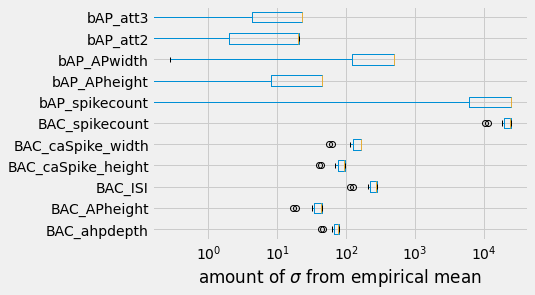

In [23]:
%matplotlib inline
I.plt.style.use("fivethirtyeight")
diff = (objectives - empirical_data['mean']) / empirical_data["std"]
ax = diff.plot.box(vert=False)
ax.set_xscale('log')
ax.set_xlabel("amount of $\sigma$ from empirical mean")

See [the previous tutorial](./1.2%20Evaluation.ipynb) for more information on how to evaluate biophysically detailed single-cell models.

## Exploration from seedpoint

Given a biophysical model that performs well on all objectives, it is possible to continuously make variations on the biophysical parameters, while monitoring how well it performs on pre-defined benchmarks (in this case, the ones described above).

This is conveniently packaged in [`biophysics_fitting.exploration_from_seedpoint`](../../../biophysics_fitting/exploration_from_seedpoint/__init__.py).

> **If you don't have a seedpoint yet**, we recommend running a Multi-Objective Optimization Algorithm first, e.g. the evolutionary algorithm [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) (see [the section above](./1.3%20Generation.ipynb) for an example application of BluePyOpt to an L5PT).

In [24]:
from biophysics_fitting.hay_complete_default_setup_python import get_Evaluator

evaluator = get_Evaluator(step=False)
simulator = db['simulator']
biophysical_parameter_ranges = db['89']['params']
example_models = db['example_models']
biophysical_parameter_names = [e for e in example_models.columns if "ephys" in e or e == "scale_apical.scale"]

In [25]:
if not I.os.path.exists(I.os.path.join(db.basedir, 'RW_exploration_example')):
    db.create_managed_folder('RW_exploration_example')

In [26]:
from biophysics_fitting.exploration_from_seedpoint.RW import RW
from biophysics_fitting.exploration_from_seedpoint.utils import evaluation_function_incremental_helper
from biophysics_fitting.hay_evaluation import hay_evaluate_bAP, hay_evaluate_BAC

evaluation_function = I.partial(
    evaluation_function_incremental_helper,  # this incremental helper stops the evaluation as soon as a stimulus protocol doesn't work.
    s=simulator,
    e=evaluator,
    stim_order=['bAP', 'BAC']
)

rw = RW(
    param_ranges = biophysical_parameter_ranges,
    df_seeds = example_models[biophysical_parameter_names],
    evaluation_function = evaluation_function,
    MAIN_DIRECTORY = db['RW_exploration_example'],
    min_step_size = 0.02,
    max_step_size = 0.02,
    checkpoint_every = 1  # This is a lot of IO. Increase this value if you are not merely doing an example.
)

Let's run this for 20 seconds. You can always restart the exploration and it will pick up from where it left off. 

In [27]:
duration = 20  # in seconds

from time import sleep
from threading import Thread
import multiprocessing

proc = multiprocessing.Process(
    target=rw.run_RW, 
    kwargs={
        'selected_seedpoint': 0,
        'particle_id': 0,
        'seed': 42  # for numpy random seed
    })

# --- run for some time, then kill the process
proc.start()
sleep(duration)
proc.terminate()  # sends a SIGTERM
proc.join()

35
My random number generator seed is 42
I am particle 0 and I write to /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_data/simulation_data/biophysics/RW_exploration_example/0/0
Found preexisting RW, continue from there. Iteration 10
Loading file /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_data/simulation_data/biophysics/RW_exploration_example/0/0/10.pickle
set state of random number generator
exploration loop
New loop. Current iteration 11
Saving
Get new position
Position within boundaries found, step size is 0.02 Tested  3 positions to find one inside the box.
evaluating stimulus bAP
evaluating stimulus BAC
all stimuli successful!
Inside the space? True
Moving current position to proposed position
distance to initial seed point (normalized): 0.07119515252125708
New loop. Current iteration 12
Saving
Get new position
Position within boundaries found, step size is 0.02 Tested  1 positions to find 

In [29]:
from biophysics_fitting.exploration_from_seedpoint.RW_analysis import Load

outdir = db['RW_exploration_example'].join('0')
l = Load(
    I.get_client(),
    outdir,
    n_particles = 1)

[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/anaconda_3.8_test2/lib/python3.8/site-packages/distributed/client.py:1129: VersionMismatchWarning:

Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| tornado | 6.0.4  | 6.4       | 6.4     |
+---------+--------+-----------+---------+




In [31]:
explored_models = l.get_df().compute()
print("Explored {} new models".format(len(explored_models)))

Explored 45 new models


How much did the exploration actually explore? Let's plot out how much it deviated from it's starting point, relative to the total extent of parameter limits we allowed for

In [32]:
def normalize(df, mn, mx):
    return (df - mn)/(mx-mn)
    
mn, mx = biophysical_parameter_ranges['min'], biophysical_parameter_ranges['max']
normalized_startpoint = normalize(example_models.iloc[0][biophysical_parameter_names], mn, mx)
normalized_explored_models = normalize(explored_models[biophysical_parameter_names], mn, mx)

# calc exploration relative to startpoint, in % of total allowed parameter limits
d = I.pd.concat([normalized_explored_models, I.pd.DataFrame(normalized_startpoint).T])
d -= normalized_startpoint
d[biophysical_parameter_names] *= 100
d = d.melt(var_name='Biophysical parameter', value_name='Normalized value (%)')

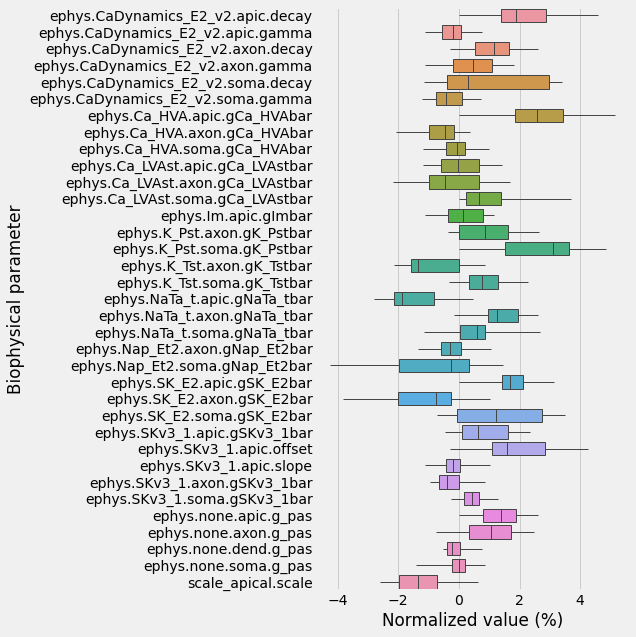

In [ ]:
I.plt.figure(figsize=(5, 10))

ax = I.sns.boxplot(
    data=d,
    y='Biophysical parameter', x='Normalized value (%)',
    whis=100,
    linewidth=1,
    showcaps = False
   )

In [47]:
delayeds = [I.dask.delayed(
    simulator.run)(p, 'BAC') for _, p in explored_models[biophysical_parameter_names].iterrows()]
f = I.get_client().compute(delayeds)

In [49]:
responses = [f_.result() for f_ in f]
BAC_responses = [response['BAC.hay_measure'] for response in responses]

soma_voltages = [
    e['vList'][0] for e in BAC_responses
]
dend_voltages = [
    e['vList'][1] for e in BAC_responses
]
time_points = [
    e['tVec'] for e in BAC_responses
]

Highlighting model nr. 17


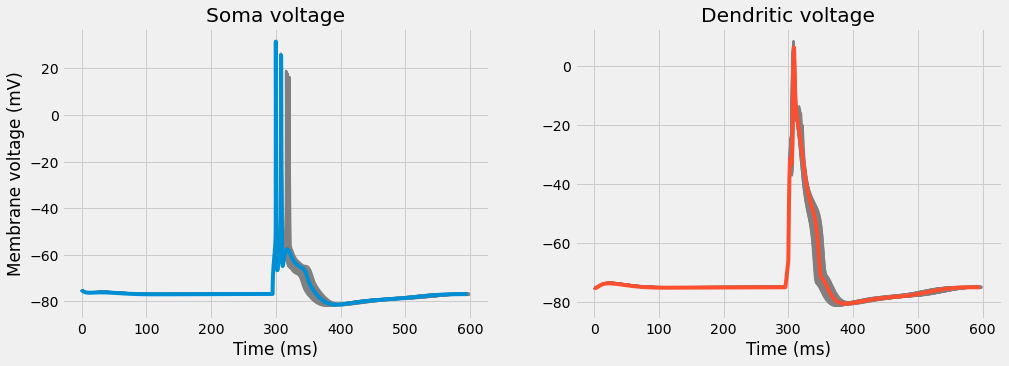

In [186]:
fig, (ax1, ax2) = I.plt.subplots(1, 2, figsize=(15, 5))
colors = I.plt.rcParams['axes.prop_cycle'].by_key()['color']                       
random_model = I.np.random.randint(0, len(BAC_responses))
print("Highlighting model nr. {}".format(random_model))

for t, v in zip(time_points, soma_voltages):
    ax1.plot(t, v, c='grey', lw=2)
ax1.plot(time_points[random_model], soma_voltages[random_model], c=colors[0])
ax1.set_title("Soma voltage")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Membrane voltage (mV)")

for t, v in zip(time_points, dend_voltages ):
    ax2.plot(t, v, c='grey', lw=2)
ax2.plot(time_points[random_model], dend_voltages[random_model], c=colors[1])
ax2.set_title("Dendritic voltage")
ax2.set_xlabel("Time (ms)")
I.plt.show()